In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [2]:
directory = "/content/drive/MyDrive/496g"


In [3]:
image_arrays = []
mask_arrays = []


In [4]:
# Get a list of all the image filenames
image_filenames = sorted(os.listdir(os.path.join(directory, "images")))

# Iterate through the sorted image filenames and add their corresponding arrays to image_arrays
for filename in image_filenames:
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        image = np.array(Image.open(os.path.join(directory, "images", filename)))
        image_arrays.append(image)

In [5]:
# Get a list of all the mask filenames
mask_filenames = sorted(os.listdir(os.path.join(directory, "masks")))

# Iterate through the sorted mask filenames and add their corresponding arrays to mask_arrays
for filename in mask_filenames:
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        mask = np.array(Image.open(os.path.join(directory, "masks", filename)))
        mask = cv2.cvtColor(mask, 1)
        mask_arrays.append(mask)

In [6]:

# Convert the list of image and mask arrays to numpy arrays
image_arrays = np.array(image_arrays)
mask_arrays = np.array(mask_arrays)



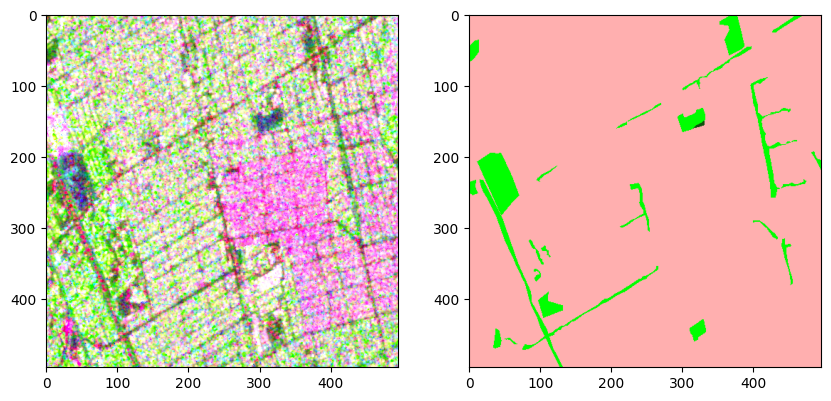

In [7]:
#Sanity check, view few images
import random
import numpy as np
image_number = random.randint(0, len(image_arrays))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image_arrays[image_number])
plt.subplot(122)
plt.imshow(mask_arrays[image_number])
plt.show()


In [8]:


forest = '#0f510d'
forest = np.array([int(forest[i:i+2], 16) for i in (1, 3, 5)])


vegetation = '#00ff00'
vegetation = np.array([int(vegetation[i:i+2], 16) for i in (1, 3, 5)])




urban = '#ffafaf'
urban= np.array([int(urban[i:i+2], 16) for i in (1, 3, 5)])



water= '#0000ff'
water = np.array([int(water[i:i+2], 16) for i in (1, 3, 5)])


label = mask




In [9]:





def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == forest,axis=-1)] = 0
    label_seg [np.all(label==vegetation,axis=-1)] = 1
    label_seg [np.all(label==urban,axis=-1)] = 2
    label_seg [np.all(label==water,axis=-1)] = 3
   
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg





labels = []
for i in range(mask_arrays.shape[0]):
    label = rgb_to_2D_label(mask_arrays[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)



In [10]:

labels = []
for i in range(mask_arrays.shape[0]):
    label = rgb_to_2D_label(mask_arrays[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)


In [11]:

print("Unique labels in label dataset are: ", np.unique(labels))



Unique labels in label dataset are:  [0 1 2 3]


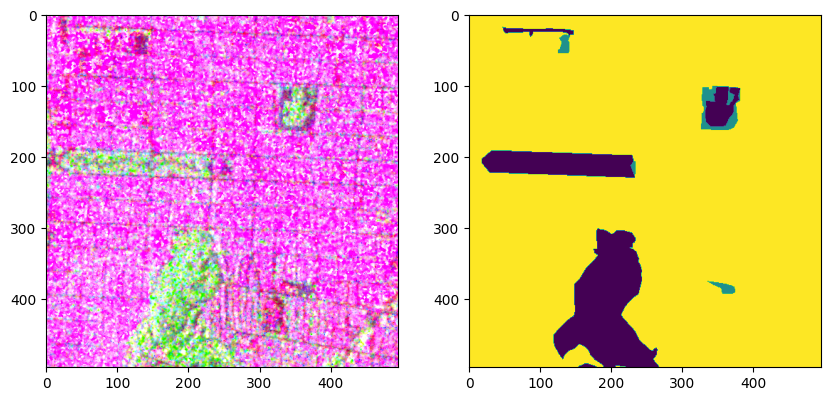

In [12]:


#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_arrays))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image_arrays[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()


In [13]:


n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)



In [14]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_arrays, labels_cat, test_size = 0.20, random_state = 42)



In [15]:
!pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
!pip install --upgrade segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [18]:

weights = [0.25, 0.25, 0.25, 0.25]
#dice_loss = sm.losses.DiceLoss(class_weights=weights) 
#focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)  


In [19]:
import tensorflow as tf
from keras import backend as K

def focal_loss(alpha=1, gamma=3):
    def focal_loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_factor = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        focal_weight = alpha_factor * K.pow(1 - pt, gamma)
        cross_entropy = -K.log(y_pred) * y_true
        loss = focal_weight * cross_entropy
        return K.mean(loss)
    return focal_loss_fn


In [20]:

import keras.backend as K
from keras.utils import get_custom_objects

def dice_loss_plus_1focal_loss(y_true, y_pred):
    # custom loss function implementation
    pass


    
import keras.backend as K
from keras.utils import get_custom_objects

def focal_loss_fn(y_true, y_pred):
    # custom loss function implementation
    pass

In [21]:

# Register the custom loss function
get_custom_objects().update({'dice_loss_plus_1focal_loss': dice_loss_plus_1focal_loss})



In [22]:

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]





In [23]:


from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda,Add,Activation
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)
    LR=0.0001

In [24]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=496, IMG_WIDTH=496, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.2)(c1) 
    c1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5) 
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5) 
    #Expansive path 
    u6 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c5)
    c6 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6) 
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7) 
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8) 
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c8)
    c9 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9) 
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [25]:
'''
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Add
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, kernel_initializer='he_normal', padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)
    x = Dropout(0.5)(x) 
    x = Conv2D(num_filters, 3, kernel_initializer='he_normal', padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input,  num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2,  padding="same")(input)
    x = Dropout(0.4)(x)
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(n_classes=4, IMG_HEIGHT=496, IMG_WIDTH=496, IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    p1 = encoder_block(inputs, 128)
    p2 = encoder_block(p1, 64)
    p3 = encoder_block(p2, 32)
    p4 = encoder_block(p3, 16)

    b1 = conv_block(p4, 8) #Bridge

    d1 = decoder_block(b1, 16)
    d2 = decoder_block(d1, 32)
    d3 = decoder_block(d2, 64)
    d4 = decoder_block(d3, 128)
 
 
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(d4)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    
    return model'''


'\nfrom keras.models import Model\nfrom keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Add\nfrom keras.optimizers import Adam\nfrom keras.layers import Activation, MaxPool2D, Concatenate\n\n\ndef conv_block(input, num_filters):\n    x = Conv2D(num_filters, 3, kernel_initializer=\'he_normal\', padding="same")(input)\n    x = BatchNormalization()(x)   #Not in the original network. \n    x = Activation("relu")(x)\n    x = Dropout(0.5)(x) \n    x = Conv2D(num_filters, 3, kernel_initializer=\'he_normal\', padding="same")(x)\n    x = BatchNormalization()(x)  #Not in the original network\n    x = Activation("relu")(x)\n\n    return x\n\n#Encoder block: Conv block followed by maxpooling\n\n\ndef encoder_block(input, num_filters):\n    x = conv_block(input, num_filters)\n    p = MaxPool2D((2, 2))(x)\n    return x   \n\n#Decoder block\n#skip features gets input from encoder for concatenation\n\ndef decoder_block(i

In [26]:

metrics=['accuracy', jacard_coef]

def get_model():
    return   multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)


In [27]:

model = get_model()
model.compile(optimizer='adam', loss=focal_loss(alpha=1, gamma=3), metrics=metrics)
#model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 496, 496, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 496, 496, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 496, 496, 128)    512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 496, 496, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 496, 496, 128)     147584    
                                                                 
 batch_normalization_1 (Batc  (None, 496, 496, 128)    512       
 hNormalization)                                             

In [28]:
from keras.utils.vis_utils import plot_model

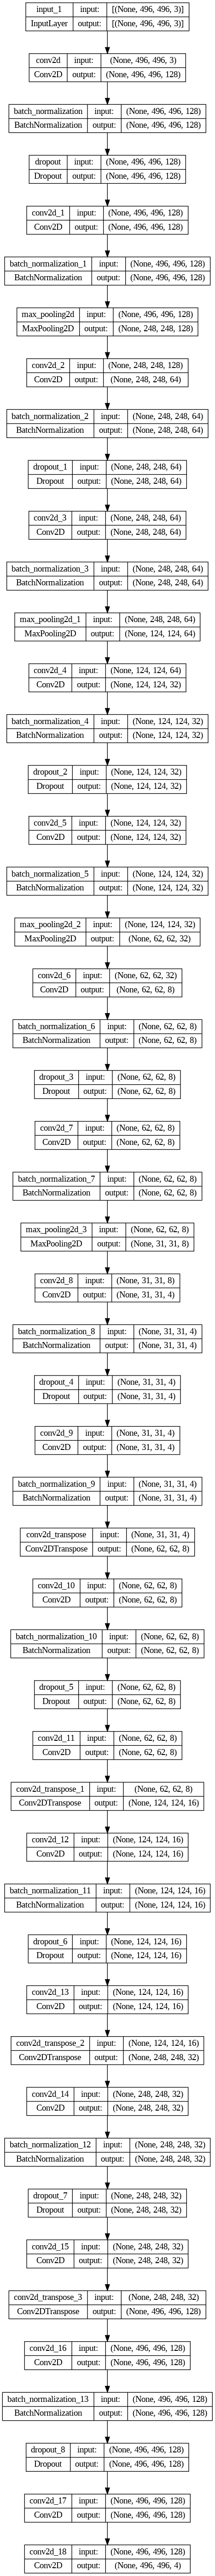

In [29]:
plot_model(model,to_file="unet_model.png",show_shapes=True,show_layer_names=True)

In [30]:
backbonehistory1 = model.fit(X_train, y_train, 
                    batch_size = 4, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
6/6 [==============================] - 47s 2s/step - loss: 0.2653 - accuracy: 0.3797 - jacard_coef: 0.1996 - val_loss: 0.2131 - val_accuracy: 0.0892 - val_jacard_coef: 0.1175
Epoch 2/100
6/6 [==============================] - 5s 843ms/step - loss: 0.1704 - accuracy: 0.3550 - jacard_coef: 0.1934 - val_loss: 0.5300 - val_accuracy: 0.0436 - val_jacard_coef: 0.0673
Epoch 3/100
6/6 [==============================] - 5s 843ms/step - loss: 0.1390 - accuracy: 0.5106 - jacard_coef: 0.2359 - val_loss: 2.5943 - val_accuracy: 0.0478 - val_jacard_coef: 0.0244
Epoch 4/100
6/6 [==============================] - 5s 849ms/step - loss: 0.1255 - accuracy: 0.4584 - jacard_coef: 0.2063 - val_loss: 3.2222 - val_accuracy: 0.0674 - val_jacard_coef: 0.0333
Epoch 5/100
6/6 [==============================] - 5s 850ms/step - loss: 0.1208 - accuracy: 0.4870 - jacard_coef: 0.2131 - val_loss: 3.5397 - val_accuracy: 0.0425 - val_jacard_coef: 0.0173
Epoch 6/100
6/6 [==============================] - 5s 857

In [31]:

model.save('models/satellite_standard_fcn_with_500epochs496*496.hdf5')

In [32]:

from keras.models import load_model
model = load_model("models/satellite_standard_fcn_with_500epochs496*496.hdf5",
                   compile=False)




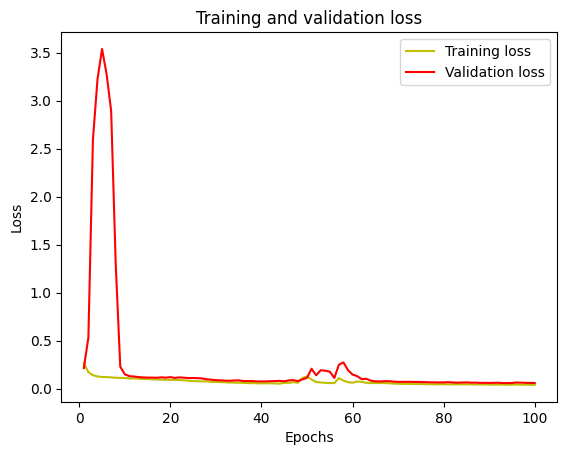

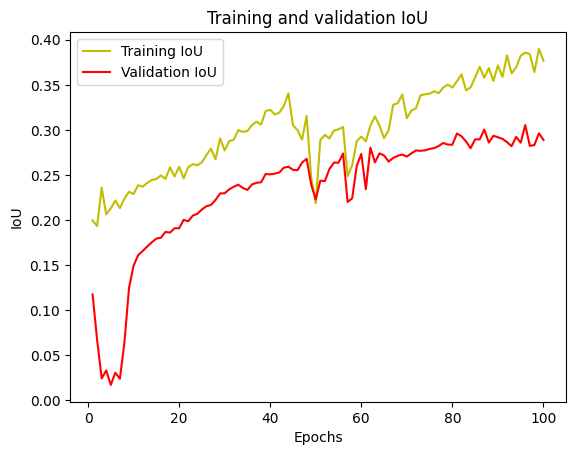

In [33]:


history = backbonehistory1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [34]:


#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 4s 4s/step
Mean IoU = 0.409634


1/1 [==============================] - 0s 100ms/step


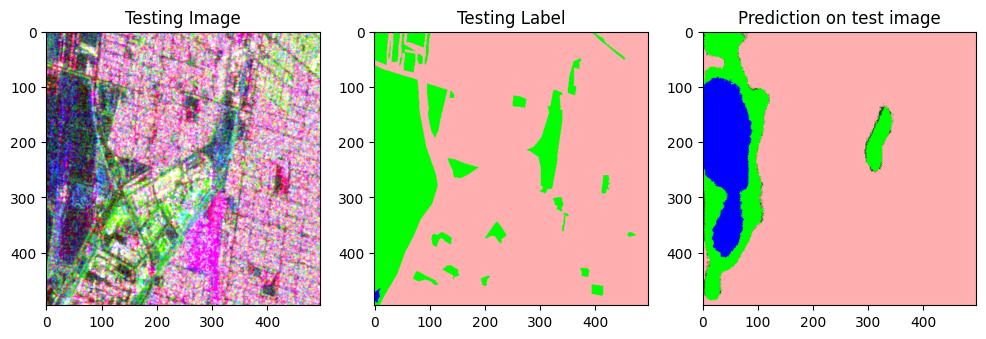

In [35]:
import random
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
prediction = model.predict(test_img_input)
predicted_img = np.argmax(prediction, axis=3)[0, :, :]

# Define colors for each class (excluding background)
colors = [
    '#0f510d',  # class 1 (red)
    '#00ff00',
    '#ffafaf',
    '#0000ff'
    # class 2 (green)
    # add more colors for additional classes...
]

# Convert hex colors to RGB values
rgb_colors = [mcolors.hex2color(color) for color in colors]

# Map pixel values to colors for ground truth label
ground_truth_color = np.zeros((ground_truth.shape[0], ground_truth.shape[1], 3), dtype=np.uint8)
for i in range(len(colors)):
    mask = (ground_truth == i)
    ground_truth_color[mask] = np.array(rgb_colors[i]) * 255

# Convert predicted image to RGB format using the same colors
predicted_img_color = np.zeros((predicted_img.shape[0], predicted_img.shape[1], 3), dtype=np.uint8)
for i in range(len(colors)):
    mask = (predicted_img == i)
    predicted_img_color[mask] = np.array(rgb_colors[i]) * 255

# Plot images
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_color)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img_color)
plt.show()


In [36]:
import os
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive')


# Set the directory path to save the images
save_dir_1 = '/content/drive/MyDrive'

if not os.path.exists('save_dir_5'):
    os.makedirs('save_dir_5')


for i in range(len(X_test)):
    test_img = X_test[i]
    ground_truth = y_test_argmax[i]
    test_img_input = np.expand_dims(test_img, 0)
    prediction = model.predict(test_img_input)
    predicted_img = np.argmax(prediction, axis=3)[0, :, :]

    # Define colors for each class (excluding background)
    colors = [
        '#0f510d',  # class 1 (red)
        '#00ff00',
        '#ffafaf',
        '#0000ff'
        # class 2 (green)
        # add more colors for additional classes...
    ]

    # Convert hex colors to RGB values
    rgb_colors = [mcolors.hex2color(color) for color in colors]

    # Map pixel values to colors for ground truth label
    ground_truth_color = np.zeros((ground_truth.shape[0], ground_truth.shape[1], 3), dtype=np.uint8)
    for j in range(len(colors)):
        mask = (ground_truth == j)
        ground_truth_color[mask] = np.array(rgb_colors[j]) * 255

    # Convert predicted image to RGB format using the same colors
    predicted_img_color = np.zeros((predicted_img.shape[0], predicted_img.shape[1], 3), dtype=np.uint8)
    for j in range(len(colors)):
        mask = (predicted_img == j)
        predicted_img_color[mask] = np.array(rgb_colors[j]) * 255

    # Save the images and labels
    filename = f'save_dir_5/test_{i}.png'
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth_color)
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img_color)
    plt.savefig(filename)
    plt.close()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 22ms/step


In [37]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [38]:
import tensorflow as tf
import datetime, os

In [39]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_arrays, labels_cat, test_size = 0.20, random_state = 72)



In [40]:
!pip install quiver_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.7/398.7 kB 34.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
